In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

5-5

In [5]:
def multivariate_normal(x, mu, cov):
    
    inv = np.linalg.inv(cov)
    D = len(x) #次元
    y = 1.0 / np.sqrt((2.0 * np.pi)**D * np.linalg.det(cov)) \
      * np.exp(-0.5 * (x - mu).T @ inv @ (x - mu))
    
    return y


def gmm(x, phis, mus, covs):
    K = len(phis)
    y = 0.0
    for k in range(K):
        phi, mu, cov = phis[k], mus[k], covs[k]
        y += phi * multivariate_normal(x, mu, cov)
    
    return y


def likelihood(xs, phis, mus, covs):
    eps = 1e-8
    L = 0 
    N = len(xs)
    for x in xs:
        y = gmm(x, phis, mus, covs)
        L += np.log(y + eps) # log0を避けるため
    
    return L / N

In [6]:
xs = np.loadtxt("old_faithful.txt")

phis = [0.5, 0.5]
mus = [[0.0, 50.0], [0.0, 100.0]]
covs = [np.eye(2), np.eye(2)]

K = len(phis)
N = len(xs)
MAX_ITERS = 100
THRESHOLD = 1e-4

In [7]:
current_likelihood = likelihood(xs, phis, mus, covs)

for iter in range(MAX_ITERS):
    
    # E-step
    qs = np.zeros([N, K])
    for n in range(N):
        x = xs[n]
        for k in range(K):
            phi, mu, cov = phis[k], mus[k], covs[k]
            qs[n, k] = phi * multivariate_normal(x, mu, cov)
        
        qs[n] /= gmm(x, phis, mus, covs)
    
    
    # M-step
    qs_sum = qs.sum(axis=0)
    for k in range(K):
        phis[k] = qs_sum[k] / N 

        c = 0.0
        for n in range(N):
            c += qs[n, k] * xs[n]
        mus[k] = c / qs_sum[k]

        c = 0.0
        for n in range(N):
            z = xs[n] - mus[k]
            z = z[:, np.newaxis]
            c += qs[n, k] * z @ z.T
        covs[k] = c / qs_sum[k]
    

    # 終了判定
    print(f"likelihood : {current_likelihood:.3f}")

    next_likelihood = likelihood(xs, phis, mus, covs)
    diff = np.abs(next_likelihood - current_likelihood)
    if diff < THRESHOLD:
        break 

    current_likelihood = next_likelihood

likelihood : -16.538
likelihood : -4.415
likelihood : -4.357
likelihood : -4.302
likelihood : -4.245
likelihood : -4.200
likelihood : -4.164
likelihood : -4.156
likelihood : -4.155


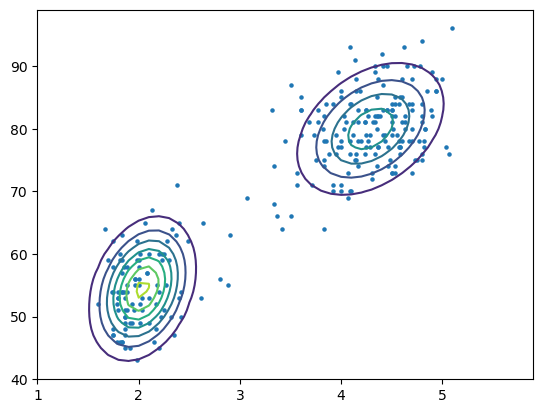

In [12]:
x, y = np.arange(1.0, 6.0, 0.1), np.arange(40, 100, 1)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)

for k in range(K):
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            x = np.array([X[i, j], Y[i, j]])
            Z[i, j] += multivariate_normal(x, mus[k], covs[k])


plt.scatter(xs[:500, 0], xs[:500, 1], s=5)
plt.contour(X, Y, Z)

plt.show()

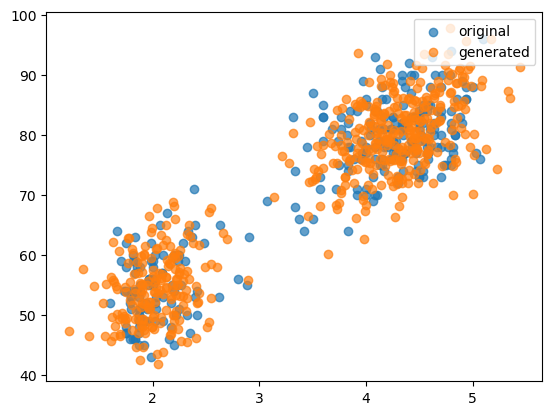

In [17]:
N = 500
new_xs = np.zeros([N, 2])

for n in range(N):
    k = np.random.choice(2, p=phis)
    mu, cov = mus[k], covs[k]
    new_xs[n] = np.random.multivariate_normal(mu, cov)


plt.scatter(xs[:, 0], xs[:, 1], alpha=0.7, label="original")
plt.scatter(new_xs[:, 0], new_xs[:, 1], alpha=0.7, label="generated")
plt.legend(loc='upper right')
plt.show()